## Imports

In [0]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import cv2

## Load data

a) Zipped (on `Google Colab`)




In [0]:
import sys
from zipfile import ZipFile
from PIL import Image

def load_data_from_zip(path, limit=None):
  images = []
  with ZipFile(path) as archive:
    entries = archive.infolist() if not limit else archive.infolist()[:limit]
    for idx, entry in enumerate(entries):
      with archive.open(entry) as file:
        if file.name.endswith('.jpg'):
          with Image.open(file) as img:
            images.append(np.asarray(img))
  return np.array(images)


b) Using `openCV`

In [0]:
def load_data(path):
  return np.array([cv2.imread(os.path.join(path, f)) for f in os.listdir(path)])

In [5]:
path = '32x32.zip'
trainX = load_data_from_zip(path)
print('Train', trainX.shape)

Train (63569, 32, 32, 3)


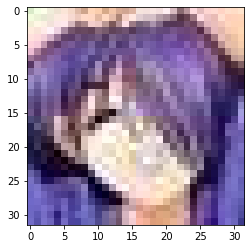

In [6]:
plt.imshow(trainX[0])
plt.show()

## Preview cutie anime facezzz

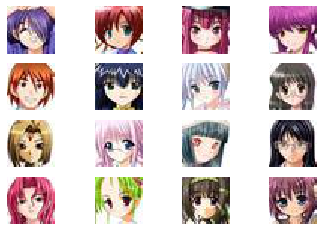

In [7]:
# plot images from the training dataset
for i in range(16):
    # define subplot
    plt.subplot(4, 4, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(trainX[i])
    
plt.show()

## Define the Discriminator

In [133]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()

    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define model
model = define_discriminator()
# summarize the model
model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_157 (LeakyReLU)  (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_158 (LeakyReLU)  (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 4096)            

### Prepare data for training

In [9]:
def convert_trainX(trainX):
    X = trainX.astype('float32')
    X = X / 255.0
    return X

dataset = convert_trainX(trainX)
dataset.shape

(63569, 32, 32, 3)

### Define methods for generating:
- real samples (just sample from the dataset)
- random fake samples - all the values are random and they represent noise

In [0]:
# select real samples + their labels: 1 for REAL as 0 represents FAKE
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = np.random.rand(32 * 32 * 3 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 32, 32, 3))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

### Train the Discriminator on real + randomly generated images

In [11]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        if i % 10 == 0:
          print('>%d real=%.0f%% fake=%.0f%%' % (i, real_acc*100, fake_acc*100))

# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model, dataset)









>0 real=43% fake=41%
>10 real=87% fake=38%
>20 real=92% fake=62%
>30 real=95% fake=76%
>40 real=98% fake=95%
>50 real=98% fake=98%
>60 real=99% fake=100%
>70 real=96% fake=100%
>80 real=98% fake=100%
>90 real=98% fake=100%


### Define the Generator

In [0]:
from keras.layers import BatchNormalization, ReLU, Lambda
from keras.backend import constant

In [134]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
#     model.add(BatchNormalization())
    # model.add(LeakyReLU(alpha=0.2))
    model.add(ReLU())
    model.add(Reshape((8, 8, 128)))

    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
#     model.add(BatchNormalization())
    # model.add(LeakyReLU(alpha=0.2))
    model.add(ReLU())

    model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
#     model.add(BatchNormalization())
    # model.add(LeakyReLU(alpha=0.2))
    model.add(ReLU())

    model.add(Conv2D(3, (8,8), activation='tanh', padding='same', name="output"))

    if model.get_layer(name='output').activation.__name__ == 'tanh':
      model.add(Lambda(lambda x: (x + constant(1.0)) / constant(2.0), name="tanh-shift"))

    return model

def get_model_summary_string(model):
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x), line_length=120)
  return "\n".join(stringlist)

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
print(get_model_summary_string(model))

Model: "sequential_67"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
dense_56 (Dense)                                      (None, 8192)                                    827392            
________________________________________________________________________________________________________________________
re_lu_1 (ReLU)                                        (None, 8192)                                    0                 
________________________________________________________________________________________________________________________
reshape_42 (Reshape)                                  (None, 8, 8, 128)                               0                 
________________________________________________________________________________________________________________________
conv2d_tr

### Define methods for generating:
- latent points for the generator
- fake samples using the generator model

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples_with_generator(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)

    ''' NOT USED NOW
    # check generator's output activation as it changes output range
    if g_model.get_layer(name='output').activation.__name__ == 'tanh':
      # if tanh, change [-1, 1] range into [0, 1]
      X = X + 1.0 / 2.0
    elif model.get_layer(name='output').activation.__name__ == 'sigmoid':
      # if sigmoid, do nothing
      pass
    else:
      raise Exception("Other activations in generator's output are not supported yet!")
    '''

    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

### Preview what the Generator generates without training

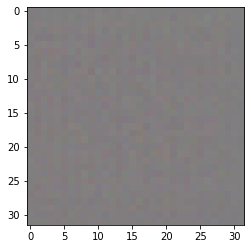

In [136]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 4
X, _ = generate_fake_samples_with_generator(model, latent_dim, n_samples)
plt.imshow(X[0, :, :])
# show the figure
plt.show()

### Define the generator+discriminator model that will update generator's weights
- the generator's aim is to produce fake samples that look like real samples
- backpropagation will not modify discriminator's weights

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

### Define the `train` method for both generator and discriminator
1. Train discriminator on 50% real samples (from the dataset) and 50% fake samples generated by the generator
2. Train generator as follows:
  - feed latent points into the generator
  - take generator's output and input to the discriminator
  - compute discriminator's loss when all generated samples' labels were '1' ("REAL")
  - update generator's weights accordingly
    - discriminator outputs 0.25: bigger penalty (poor 'fake' sample)
    - discriminator outputs 0.9: smaller penalty (good 'fake' sample)

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256, save_every=10, label=None):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    acc_real_list, acc_fake_list = [], []
    loss_real_list, loss_fake_list = [], []

    timestamp = time.strftime("%Y-%m-%d_%H:%M:%S")
    if label:
      timestamp = label + '-' + timestamp

    if not os.path.isdir(timestamp):
        os.mkdir(timestamp)
    print(f">>> MODEL AND ITS EVALUATION CAN BE FOUND IN {timestamp} DIRECTORY :)")

    # dump model summary into file
    with open(os.path.join(timestamp, f"SUMMARY-{timestamp}.txt"), "w") as summary_file:
      summary_file.write("DISCRIMINATOR:\n")
      summary_file.write(get_model_summary_string(d_model))
      summary_file.write("\nGENERATOR:\n")
      summary_file.write(get_model_summary_string(g_model))

    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples_with_generator(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # train distriminator with 50% fake examples and 50% real examples
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # summarize loss on this batch
            # print('\t >%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

        # EVALUATION
        n_samples = 64
        # prepare real samples
        X_real, y_real = generate_real_samples(dataset, n_samples)
        # evaluate discriminator on real examples
        loss_real, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
        acc_real_list.append(acc_real); loss_real_list.append(loss_real)

        # prepare fake examples
        x_fake, y_fake = generate_fake_samples_with_generator(g_model, latent_dim, n_samples)
        # evaluate discriminator on fake examples
        loss_fake, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
        acc_fake_list.append(acc_fake); loss_fake_list.append(loss_fake)

        print('\n> %d, real_acc=%.3f, fake_acc=%.3f' % (i+1, acc_real, acc_fake))
        print('> %d, real_loss=%.3f, fake_loss=%.3f\n' % (i+1, loss_real, loss_fake))

        if (i+1) % save_every == 0:
            print()
            # save generating images result
            save_images_plot(x_fake, i, timestamp=timestamp, n=8)

            # save plot with accuracy
            save_measure_plot(acc_real_list, acc_fake_list, i, label='accuracy', timestamp=timestamp)

            # save plot with loss
            save_measure_plot(loss_real_list, loss_fake_list, i, label='loss', timestamp=timestamp)

            # save model
            save_model(g_model, i, timestamp=timestamp)

### [utils] Define `save_measure_plot` function
This method creates a plot with two lines representing discriminator's performance (e.g. accuracy or loss) on real and fake (generated) images accross epochs. The plot is saved to file according to the model's timestamp (or label+timestamp)

In [0]:
def save_measure_plot(real_list, fake_list, epoch, label='accuracy', timestamp=''):
    print("[ ] Creating plots for %s, epoch %d..." % (label, epoch+1))
    # filename = '%s_%s_plot_e%03d.png' % (timestamp, label, epoch+1)
    filename = '%s_%s_plot.png' % (timestamp, label)
    plt.figure(figsize=(14, 5))

    # plt.subplot(121)
    plt.plot([i for i in range(len(real_list))], real_list, label=f"real {label}")

    # plt.subplot(122)
    plt.plot([i for i in range(len(fake_list))], fake_list, label=f"fake {label}")
    plt.title("real / fake %s" % (label))
  
    plt.legend(loc="best")
    plt.savefig(os.path.join(timestamp, filename))
    plt.close()

### [utils] Define `save_images_plot` function
This method creates a plot with n*n images generated using the generator model and saves it.

In [0]:
# create and save a plot of generated images (reversed grayscale)
def save_images_plot(examples, epoch, n=4, timestamp=''):
    print("[ ] Creating images preview of %d examples, epoch %d..." % (n*n, epoch+1))
    plt.figure(figsize=(15,15))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i], alpha=1.0)
    filename = '%s_generated_plot_e%03d.png' % (timestamp, epoch+1)
    plt.savefig(os.path.join(timestamp, filename))
    plt.close()

### [utils] Define `save_model` function
This method saves current model under timestamp/model/ directory for further usage. Each filename contains information about the epoch number.

In [0]:
def save_model(g_model, epoch, timestamp=''):
    if not os.path.isdir(os.path.join(timestamp, 'model')):
        os.mkdir(os.path.join(timestamp, 'model'))
    filename = os.path.join(timestamp, 'model', 'generator_%03d.h5' % (epoch + 1))
    g_model.save(filename)

## TRAIN! It's here

In [0]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256, save_every=10, label='TANH2')

>>> MODEL AND ITS EVALUATION CAN BE FOUND IN TANH2-2019-12-18_21:12:55 DIRECTORY :)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



> 1, real_acc=0.469, fake_acc=0.969
> 1, real_loss=0.693, fake_loss=0.651


> 2, real_acc=0.078, fake_acc=0.984
> 2, real_loss=0.741, fake_loss=0.669


> 3, real_acc=0.016, fake_acc=1.000
> 3, real_loss=0.767, fake_loss=0.586


> 4, real_acc=0.031, fake_acc=1.000
> 4, real_loss=0.789, fake_loss=0.545


> 5, real_acc=0.359, fake_acc=0.969
> 5, real_loss=0.706, fake_loss=0.648


> 6, real_acc=0.703, fake_acc=0.234
> 6, real_loss=0.663, fake_loss=0.707


> 7, real_acc=0.297, fake_acc=0.984
> 7, real_loss=0.708, fake_loss=0.650


> 8, real_acc=0.328, fake_acc=0.750
> 8, real_loss=0.715, fake_loss=0.659


> 9, real_acc=0.734, fake_acc=0.016
> 9, real_loss=0.666, fake_loss=0.755


> 10, real_acc=0.500, fake_acc=0.672
> 10, real_loss=0.694, fake_loss=0.675


[ ] Creating images preview of 64 examples, epoch 10...
[ ] Creating plots for accuracy, epoch 10...
[ ] Creating plots for loss, epoch 10...

> 11, real_acc=0.750, fake_acc=0.016
> 11, real_loss=0.675, fake_loss=0.729


> 12, real_acc=0

(0.0003286898, 0.9988538)

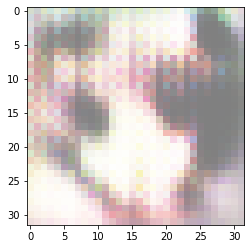

In [59]:
# generate images
num_images = 64
# generate images
X, _ = generate_fake_samples_with_generator(g_model, 100, num_images)
idx = np.random.randint(0, num_images)
plt.imshow(X[idx])
np.min(X[idx]), np.max(X[idx])

In [0]:
# example of loading the generator model and generating images
from keras.models import load_model

timestamp = "2019-12-13_15:49:41"
# load model
model1 = load_model(timestamp + '/model/generator_060.h5')
# generate images
latent_points = generate_latent_points(100, 64)
# generate images
X = model1.predict(latent_points)
# plot the result
save_images_plot(X, 99, timestamp=timestamp, n=8)

In [0]:
! rm -rf TANH2-2019-12-18_*